In [51]:
# setting up
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.functions import regexp_extract, col, sum as spark_sum
import re
import pandas as pd
import glob

sqlContext = SQLContext(sc)
spark = SparkSession(sc)

# grab logfile
log_file = glob.glob('*.logs')

# save logfile in dataframe 
base_df = spark.read.text(log_file)

# retrieve value from data frame
df_value = [item['value'] for item in base_df.take(base_df.count())]

# filter out nginx from logfile
nginx_pattern = r'\S*nginx_1 '
nginx_list = []
for item in df_value:
    if re.search(nginx_pattern, item):
        nginx_list.append(item)

# creating a dataframe object from listoftuples
nginx_df = spark.createDataFrame(nginx_list, StringType())
type(nginx_df)

# extract nginx value in dataframe
nginx_value = [item['value'] for item in nginx_df.take(nginx_df.count())]

# declaring patterns to be stored
host_pattern = r'(\d+\.\d+\.\d+\.\d+)\s'
ts_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} \+\d{4})'
method_uri_protocol_pattern = r'\"(\S+)\s(\S+)\s*(\S*)\"'
status_pattern = r'\s(\d{3})\s'
content_size_pattern = r'\s\d{3}\s(\d+)'

# build data frame with logs attribute
cleaned_logs = nginx_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                         regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                         regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                         regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                         regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                         regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                         regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))

# filter bad rows
bad_rows_df = cleaned_logs.filter(cleaned_logs['host'].isNull()| 
                             cleaned_logs['timestamp'].isNull() | 
                             cleaned_logs['method'].isNull() |
                             cleaned_logs['endpoint'].isNull() |
                             cleaned_logs['status'].isNull() |
                             cleaned_logs['content_size'].isNull()|
                             cleaned_logs['protocol'].isNull())

# remove null rows
cleaned_logs = cleaned_logs[cleaned_logs['status'].isNotNull()]


In [52]:
# convert timestampms into actual timestamps
month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(text):
    """ Convert Common Log time format into a Python datetime object
    Args:
        text (str): date and time in Apache time format [dd/mmm/yyyy:hh:mm:ss (+/-)zzzz]
    Returns:
        a string suitable for passing to CAST('timestamp')
    """
    # NOTE: We're ignoring the time zones here, might need to be handled depending on the problem you are solving
    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(text[7:11]),
      month_map[text[3:6]],
      int(text[0:2]),
      int(text[12:14]),
      int(text[15:17]),
      int(text[18:20])
    )

# convert timestamp into Python datatime object
udf_parse_time = udf(parse_clf_time)

cleaned_logs = cleaned_logs.select('*', udf_parse_time(cleaned_logs['timestamp']).cast('timestamp').alias('time')).drop('timestamp')

# data are ready for analysis
cleaned_logs.cache()

DataFrame[host: string, method: string, endpoint: string, protocol: string, status: int, content_size: int, time: timestamp]

In [54]:
#perform exploratory data analysis(EDA)
#perform some stats on the content size
from pyspark.sql import functions as F

(cleaned_logs.agg(F.min(cleaned_logs['content_size']).alias('min_content_size'),
             F.max(cleaned_logs['content_size']).alias('max_content_size'),
             F.mean(cleaned_logs['content_size']).alias('mean_content_size'),
             F.stddev(cleaned_logs['content_size']).alias('std_content_size'),
             F.count(cleaned_logs['content_size']).alias('count_content_size'))
        .toPandas())

min_content_size  max_content_size  mean_content_size  std_content_size  \
0                 0            293539        1546.077002      11508.753536   

   count_content_size  
0                1948

In [55]:
#http status code analysis
status_freq_df = (cleaned_logs
                     .groupBy('status')
                     .count()
                     .sort('status')
                     .cache())
print('Total distinct HTTP Status Codes:', status_freq_df.count())
status_freq_pd_df = (status_freq_df
                         .toPandas()
                         .sort_values(by=['count'],
                                      ascending=False))
status_freq_pd_df

Total distinct HTTP Status Codes: 7


status  count
4     405   1270
0     200    642
2     400     15
3     404     15
1     304      3
6     502      2
5     500      1

In [66]:
#log transforms help us transform highly skewed data to an approximate normal distribution
log_freq_df = status_freq_df.withColumn('log(count)',
                                        F.log(status_freq_df['count']))
log_freq_df.show()

+------+-----+------------------+
|status|count|        log(count)|
+------+-----+------------------+
|   200|  642| 6.464588303689961|
|   304|    3|1.0986122886681098|
|   400|   15|  2.70805020110221|
|   404|   15|  2.70805020110221|
|   405| 1270| 7.146772179452637|
|   500|    1|               0.0|
|   502|    2|0.6931471805599453|
+------+-----+------------------+



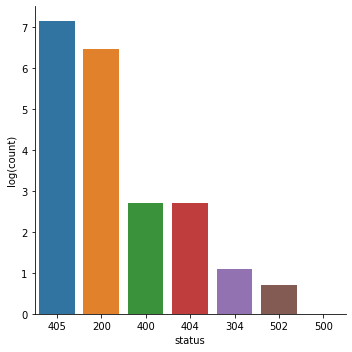

In [67]:
#HTTP status code frequency bar chart, after a log transform
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
log_freq_pd_df = (log_freq_df
                    .toPandas()
                    .sort_values(by=['log(count)'],
                                 ascending=False))
sns.catplot(x='status', y='log(count)', data=log_freq_pd_df, 
            kind='bar', order=status_freq_pd_df['status'])

In [68]:
#frequent hosts
host_sum_df =(cleaned_logs
               .groupBy('host')
               .count()
               .sort('count', ascending=False).limit(10))
host_sum_df.cache() # to be used later

host_sum_df.show(truncate=False)

+--------------+-----+
|host          |count|
+--------------+-----+
|62.234.142.152|872  |
|148.163.169.39|854  |
|41.146.2.141  |100  |
|60.241.212.25 |41   |
|31.169.84.217 |2    |
|171.67.70.80  |2    |
|200.82.146.199|2    |
|121.40.229.42 |2    |
|179.98.189.55 |2    |
|14.139.185.99 |2    |
+--------------+-----+



In [69]:
#top 20 frequent endpoints
paths_df = (cleaned_logs
            .groupBy('endpoint')
            .count()
            .sort('count', ascending=False).limit(20))

paths_pd_df = paths_df.toPandas()
paths_pd_df  

endpoint  count
0                                        /phpmyadmin/    100
1                                                   /     63
2                                           /test.php     19
3                                              /1.php     16
4                                             /qq.php     12
5                                          /shell.php     10
6   /public/index.php?s=index\x5C/think\x5Capp/inv...     10
7                                    /Pages/login.htm     10
8                                            /cmd.php     10
9                                              /x.php     10
10                                         /api/users      9
11                                           /api.php      8
12                                           /log.php      8
13                                            /ss.php      8
14                                         /confg.php      8
15                                     /api/janesucks      7
16                                             /2.php      6
17                                             /q.php      6
18                                           /jsc.php      6
19                                              /api/      6

In [73]:
#top 10 error endpoints
not200_df = (cleaned_logs
               .filter(cleaned_logs['status'] != 200))

error_endpoints_freq_df = (not200_df
                               .groupBy('endpoint')
                               .count()
                               .sort('count', ascending=False)
                               .limit(10)
                          )
                         
error_endpoints_freq_df.show(truncate=False)   

+----------------+-----+
|endpoint        |count|
+----------------+-----+
|/1.php          |16   |
|/test.php       |16   |
|/qq.php         |12   |
|/Pages/login.htm|10   |
|/x.php          |8    |
|/confg.php      |8    |
|/api.php        |8    |
|/ss.php         |8    |
|/api/janesucks  |7    |
|/log.php        |6    |
+----------------+-----+



In [75]:
#frequent endpoints by specific user
top_host = (cleaned_logs
               .filter(cleaned_logs['host'] == host_sum_df.collect()[0]['host'])) # top host
top_host_paths_df =(top_host
            .groupBy('endpoint')
            .count()
            .sort('count', ascending=False).limit(10))

top_host_paths_df = top_host_paths_df.toPandas()
top_host_paths_df

endpoint  count
0   /test.php     10
1      /1.php      8
2     /qq.php      6
3      /x.php      5
4  /shell.php      5
5           /      5
6    /cmd.php      5
7    /log.php      4
8  /confg.php      4
9    /api.php      4

In [76]:
#total number of unique hosts
unique_host_count = (cleaned_logs
                     .select('host')
                     .distinct()
                     .count())
unique_host_count

79

In [77]:
# total number of 404 responses
not_found_df = cleaned_logs.filter(cleaned_logs["status"] == 404).cache()
print(('Total 404 responses: {}').format(not_found_df.count()))


Total 404 responses: 15


In [78]:
# 404 response endpoints
endpoints_404_count_df = (not_found_df
                          .groupBy("endpoint")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))
endpoints_404_count_df.show(truncate=False)

+--------------+-----+
|endpoint      |count|
+--------------+-----+
|/api.php      |8    |
|/api/janesucks|7    |
+--------------+-----+



In [79]:
# 404 response hosts
hosts_404_count_df = (not_found_df
                          .groupBy("host")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))
hosts_404_count_df.show(truncate=False)

+--------------+-----+
|host          |count|
+--------------+-----+
|60.241.212.25 |7    |
|62.234.142.152|4    |
|148.163.169.39|4    |
+--------------+-----+



In [80]:
#404 errors per day
errors_by_date_sorted_df = (not_found_df
                                .groupBy(F.dayofmonth('time').alias('day'))
                                .count()
                                .sort("day"))

errors_by_date_sorted_pd_df = errors_by_date_sorted_df.toPandas()
errors_by_date_sorted_pd_df

day  count
0    4      4
1    5      4
2    6      7

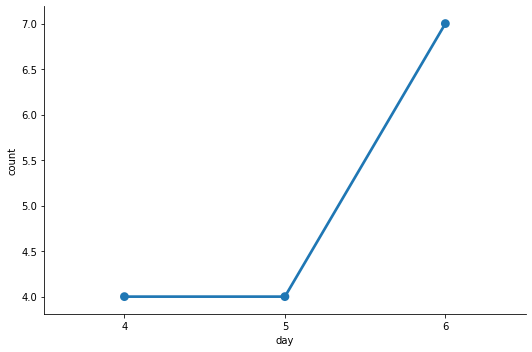

In [82]:
# 404 errors per day

c = sns.catplot(x='day', y='count', 
                data=errors_by_date_sorted_pd_df, 
                kind='point', height=5, aspect=1.5)